## Splitgraph PostGIS/GeoPandas demo

This example will:

  * Use a Splitfile to build a dataset containing precinct boundaries and Trump/Clinton
    vote fractions in each precinct in New York City
  * Use [geopandas](https://geopandas.org) to plot this data on a map.
  
**Data sources**:
  * Precinct-level maps from [election-geodata](https://github.com/nvkelso/election-geodata) compiled by Nathaniel Kelso and Michal Migurski.
  * 2016 US Presidential Election precinct-level returns ([source](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LYWX3D))

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

from splitgraph.ingestion.pandas import sql_to_df
from splitgraph.core.repository import Repository, clone
from splitgraph.core.output import pretty_size
from splitgraph.engine import ResultShape
from splitgraph.splitfile.execution import execute_commands

# Use geopandas to handle geodata-enabled DataFrames
import geopandas
from shapely.wkb import loads

# Bump up loglevel to see what happens behind the scenes.
import logging
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.INFO)

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)

First, let's inspect the `election-geodata` repository. Whilst the actual repository is about 900MiB big, we'll only be querying data for New York county, so Splitgraph will seamlessly download only the required chunks of the dataset.

In [3]:
local_repository = clone("splitgraph/election-geodata")
image = local_repository.images["latest"]
print(image)
print()
print(pretty_size(image.get_size()))

2020-08-27 22:42:19,491 Gathering remote metadata...
2020-08-27 22:42:22,991 Fetched metadata for 1 image, 1 table, 192 objects and 0 tags.


Image(image_hash='79724cbf5dcd2b260ac0d60e58135123d527ff4d2e1dc709f6da47fa8f4ee71f', parent_id=None, created=datetime.datetime(2019, 10, 11, 15, 4, 47, 225093), comment=None, provenance_data=None, repository=Repository splitgraph/election-geodata on LOCAL)

942.95 MiB


In [4]:
query = """SELECT year, precinct, geom AS geometry 
        FROM nation 
        WHERE state = '36' AND county = '061' AND ST_IsValid(geom)"""
with image.query_schema() as s:
    result = local_repository.engine.run_sql_in(s, "EXPLAIN " + query, return_shape=ResultShape.MANY_ONE)
print("\n".join(result))

Foreign Scan on nation  (cost=20.00..400000.00 rows=8000 width=50)
  Filter: (((state)::text = '36'::text) AND ((county)::text = '061'::text) AND st_isvalid(geom))
  Multicorn: Objects removed by filter: 184
  Multicorn: Scan through 8 object(s) (19.25 MiB)
JIT:
  Functions: 2
  Options: Inlining false, Optimization false, Expressions true, Deforming true


The dataset is **943MiB** large and we'll only need to download **19 MiB** of data to satisfy this query. Let's run it and import the results into a Pandas dataframe.

In [5]:
# Pass use_lq to run the query using layered querying (don't check out the whole dataset)
df = sql_to_df(query, image=image, use_lq=True)
df

,year,precinct,geometry
0,2017,3606123001,0106000000010000000103000000010000009F00000096...
1,2017,3606123002,0106000000010000000103000000010000006C000000DD...
2,2017,3606123003,010600000001000000010300000001000000AE0600004A...
3,2017,3606123004,010600000001000000010300000001000000830200003B...
4,2017,3606123005,010600000001000000010300000001000000760000008D...
...,...,...,...
5382,2017,3606137025,01060000000100000001030000000100000010010000DC...
5383,2017,3606151072,010600000001000000010300000001000000300000007A...
5384,2017,3606151075,0106000000010000000103000000010000002900000048...
5385,2017,3606162008,0106000000010000000103000000010000006E00000046...


Load the data into GeoPandas and try plotting it.

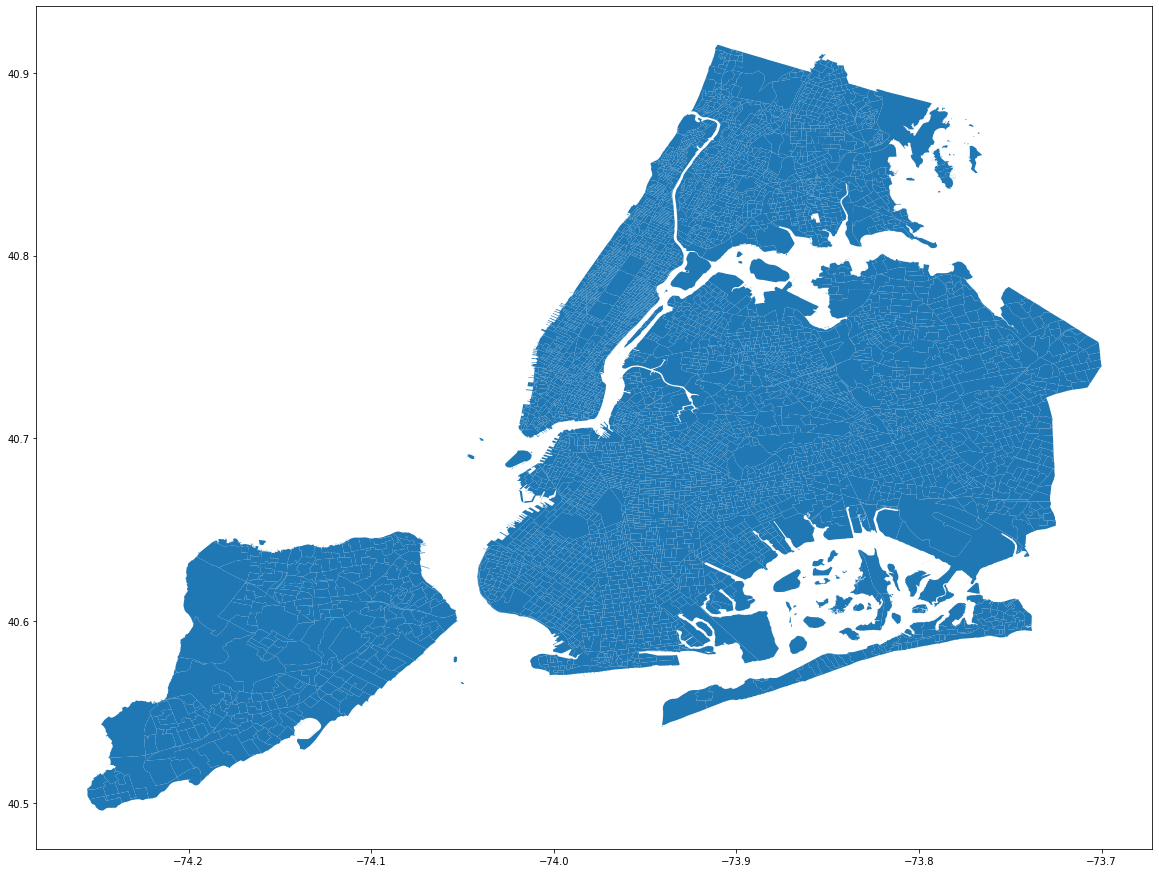

In [6]:
def load_geom(cell):
    return loads(str(cell), hex=True)

gdf = geopandas.GeoDataFrame(df)
gdf["geometry"] = gdf["geometry"].apply(load_geom)

fig = plt.figure(figsize=(20, 20))
gdf["geometry"].plot(ax=fig.gca())
plt.savefig("nyc.png", dpi=200)

That looks like New York City alright. Let's try and join this dataset with the 2016 Presidential Election precinct-level result dataset to plot a heatmap of voting patterns across NY County.

In [7]:
splitfile_path = "./vote_map.splitfile"
with open(splitfile_path) as f:
    splitfile_data = f.read()
print(splitfile_data)

# This Splitfile joins New York City precinct-level results in the 2016 election
# with voting precinct boundaries data (using PostGIS) to prepare it for plotting.

SQL {
    CREATE TABLE vote_fraction_geo AS
    WITH vote_fraction AS (
        SELECT
            -- Prepare NY precincts for joining on election-geodata precinct field
            -- NY precincts are of the format 004/65 whereas geodata precincts are
            -- 3606165004 (36 for NY State FIPS, 061 for county FIPS) -- note
            -- that precinct blocks are flipped.
            -- Also, all NYC boroughs are mapped to the Manhattan FIPS (36061)
            -- in the election-geodata dataset, so we use that county FIPS
            -- when computing the join key.
            '36061' || regexp_replace(precinct, '(.*)/(.*)', '\2\1') AS precinct,
            SUM(CASE WHEN candidate_normalized = 'trump' THEN votes ELSE 0 END) / NULLIF(SUM(votes), 0)
                AS trump_vote_fraction,
            SUM(CASE WHEN candi

We'll be using this Splitfile that will join the two datasets together. It's completely self-contained: you don't need to have the `splitgraph/2016_election:latest` or `splitgraph/election-geodata:latest` images cloned. In addition, same rules regarding object downloads apply: despite that the two datasets together take up about 1GiB, the Splitfile executor will only need to download 25MiB of data to build this derivative dataset.

In [11]:
output = Repository("", "vote_map")
execute_commands(splitfile_data, output=output)


Step 1/1 : SQL {    CREATE TABLE vote_fraction_geo AS    WITH vote...
Resolving repository splitgraph/election-geodata
Gathering remote metadata...
No image/object metadata to pull.
Resolving repository splitgraph/2016_election
Gathering remote metadata...
No image/object metadata to pull.
Executing SQL...
Committing vote_map...
Processing table vote_fraction_geo
 ---> 23ce8f4810c5
Successfully built vote_map:23ce8f4810c5.


The dataset is built and checked out for us. Let's inspect it.

In [10]:
vote_fraction_geo = sql_to_df("SELECT * FROM vote_fraction_geo",
                              image=output.images["latest"], use_lq=True)
vote_fraction_geo = geopandas.GeoDataFrame(vote_fraction_geo)
vote_fraction_geo["geometry"] = vote_fraction_geo["geometry"].apply(load_geom)
vote_fraction_geo["vote_direction"] = \
    vote_fraction_geo["clinton_vote_fraction"] - vote_fraction_geo["trump_vote_fraction"]

vote_fraction_geo

,precinct,trump_vote_fraction,clinton_vote_fraction,total_votes,year,geometry,vote_direction
0,3606123001,0.688327,0.205776,831.0,2017,"MULTIPOLYGON (((-73.91701 40.55634, -73.91626 ...",-0.482551
1,3606123002,0.698780,0.190244,820.0,2017,"MULTIPOLYGON (((-73.91313 40.56464, -73.91292 ...",-0.508537
2,3606123003,0.684211,0.204406,817.0,2017,"MULTIPOLYGON (((-73.88313 40.56838, -73.88281 ...",-0.479804
3,3606123004,0.678082,0.219178,146.0,2017,"MULTIPOLYGON (((-73.86495 40.56663, -73.86509 ...",-0.458904
4,3606123005,0.552393,0.358344,773.0,2017,"MULTIPOLYGON (((-73.85324 40.57138, -73.85274 ...",-0.194049
...,...,...,...,...,...,...,...
5170,3606187084,0.069652,0.793532,402.0,2017,"MULTIPOLYGON (((-73.85888 40.81973, -73.85967 ...",0.723881
5171,3606187086,0.023077,0.865385,260.0,2017,"MULTIPOLYGON (((-73.85158 40.82071, -73.85464 ...",0.842308
5172,3606187087,0.034976,0.907790,629.0,2017,"MULTIPOLYGON (((-73.85109 40.81862, -73.85414 ...",0.872814
5173,3606187088,0.047703,0.867491,566.0,2017,"MULTIPOLYGON (((-73.84834 40.82036, -73.84833 ...",0.819788


Finally, let's plot a heatmap of the difference between vote fractions in each precinct, using the standard color scheme (Red for Republican, Blue for Democrat).

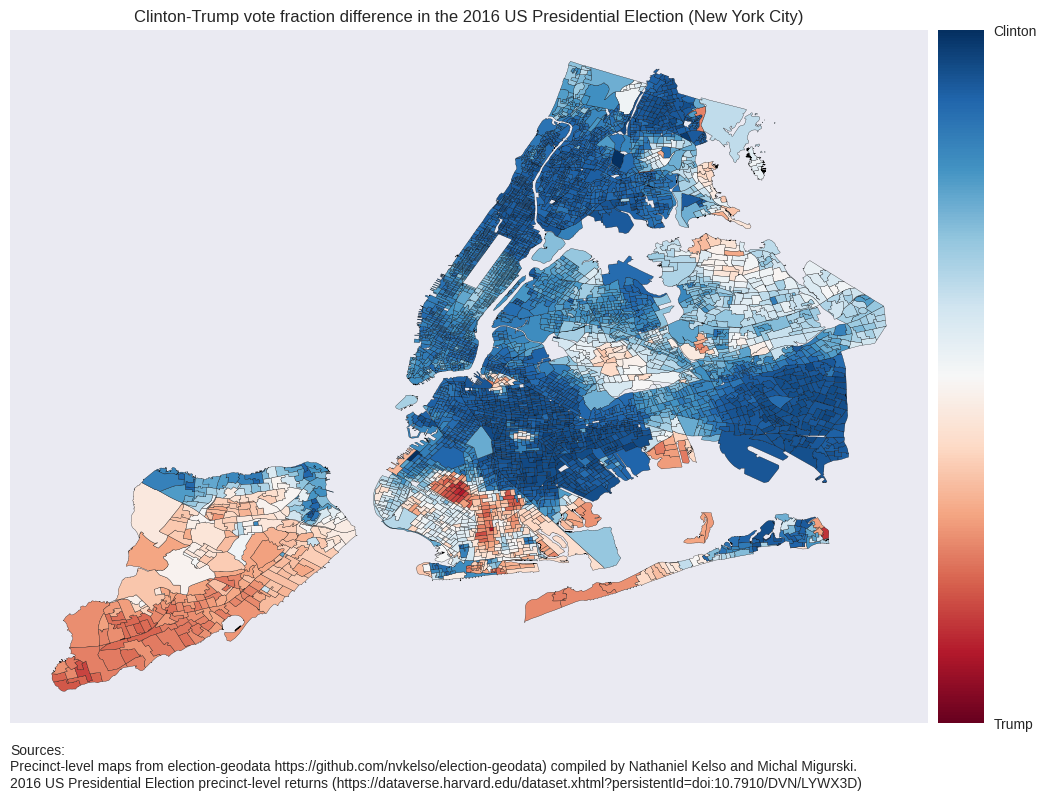

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams.update(mpl.rcParamsDefault)

plt.style.use("seaborn")
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

vote_fraction_geo.plot(column="vote_direction", ax=ax, 
                       edgecolor="black", linewidth=0.2,
                       legend=True, cmap="RdBu", legend_kwds={"ticks": [-1, 1]},
                       vmin=-1, vmax=1, cax=cax)

# Disable ticks (lat/lon, not needed)
ax.set_xticks(ticks=[])
ax.set_yticks(ticks=[])
cax.axes.set_yticklabels(["Trump", "Clinton"])

ax.title.set_text("Clinton-Trump vote fraction difference in the 2016 US Presidential Election (New York City)")
ax.annotate("Sources:\n"
             "Precinct-level maps from election-geodata https://github.com/nvkelso/election-geodata)"
             " compiled by Nathaniel Kelso and Michal Migurski.\n"
             "2016 US Presidential Election precinct-level returns "
             "(https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LYWX3D)",
             (0, -0.03), (0, 0), xycoords="axes fraction", textcoords="offset points", va="top")
plt.savefig("vote_map.png", dpi=150)